## Conversion Rate for a Shopping Website

### Problem Statement
This is a dataset about users who hit one shopping website. My goal is to identify the conversion rate of a website, i.e. to predict how likely that the site tends to turn lookers into buyers. Meanwhile, I will offer some recommendations for the team to improve conversion rate. The dataset is quite straight-forward and consists of whether the user converted or not as well as some of users charasteristics such as their country, the marketing channel, their age, whether they are new or old users and the number of pages visited during that session.

### Roadmap

1. Load the data
2. Data Cleaning
3. Exploratory Data Analysis for Insights
4. Data Preparation for Prediction
5. Establish Baseline Model
6. Try different classification Algorithms
7. Select the best model based on evaluation metric
8. Fine tune the model
9. Feature Importance
10. Recommendations 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve,roc_auc_score, classification_report
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score, accuracy_score

### Load and Inspect Data

**Data**: 316,200 observations with 5 independent and 1 dependent variable. Column **converted** will be our target label( 0 if user did not convert and 1 if he/she did). 

In [3]:
data = pd.read_csv("conversion_data.csv",sep = ",")
data.shape

(316200, 6)

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Data Summary suggests that age has an outlier. We need to investigate this further.

In [6]:
data[data.age > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Since, there are 2 observations with age greater than 100, we would remove them from the dataset to avoid any bias which might affect our analysis.

In [7]:
data = data[data.age < 100]
data.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


In [8]:
for col in data.columns:
    uniques = sorted(data[col].unique())
    print('{0:20s} {1:5d}\t'.format(col,len(uniques)),uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     58	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


Explore unique values in all the columns

### Missing value Analysis

Having missing values in your data is not necessarily a setback but it is an opportunity to perform right feature engineering to guide the model to interpret the missing information right way

In [9]:
for col in data.columns:
    miss = sum(data[col].isna())
    print('{0:30s} {1:2d}\t'.format(col,miss))

country                         0	
age                             0	
new_user                        0	
source                          0	
total_pages_visited             0	
converted                       0	


No missing values found.

# Exploratory data analysis

Let's look at the ditribution of our target variable which is "converted". We can see that our data is imbalanced containing a large number of users that have not converted and a very low number of users that converted. 

### Conversion Distribution

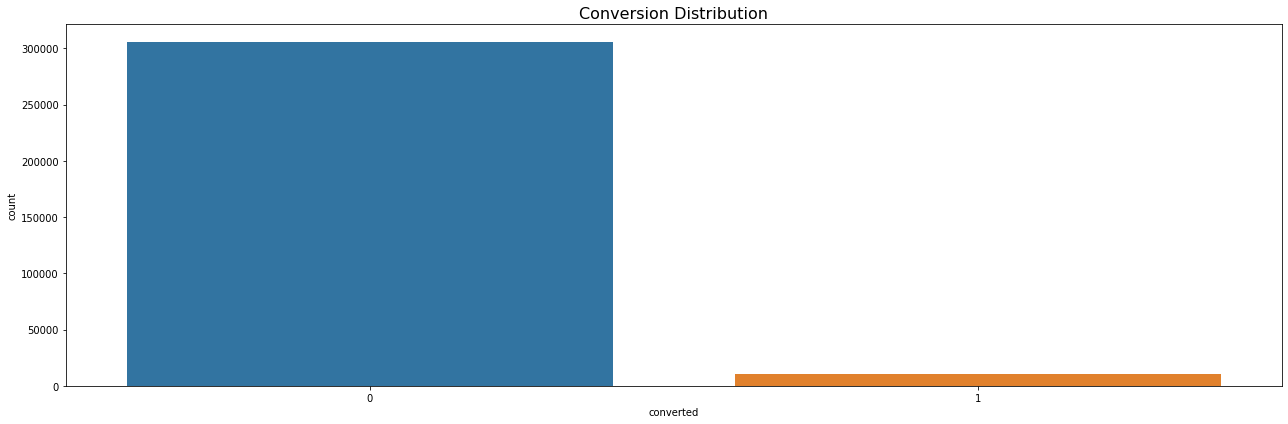

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.countplot(x='converted', data=data, ax=ax)
ax.set_title('Conversion Distribution', fontsize=16)
plt.tight_layout()
plt.show()

On a high level, we can see that out of 316,198 shoppers, 306,000 shoppers don't convert and this website has a very low conversion rate of 3.2%.

In [12]:
print(len(data))
print('Total number of shoppers who convert: ', len(data[data.converted == 1]))
print('Total number of shoppers who dont convert: ',len(data[data.converted == 0]))
print('Total Conversion Rate is: ', len(data[data['converted']==1]['converted'])/(len(data[data['converted']==1]['converted'])+len(data[data['converted']==0]['converted'])))

316198
Total number of shoppers who convert:  10198
Total number of shoppers who dont convert:  306000
Total Conversion Rate is:  0.03225194340255157


## Univariate Analysis

Univariate analysis is the simplest form of analyzing data. “Uni” means “one”, so in other words, we analyze only one variable at a time. It doesn't deal with causes or relationships (unlike regression ) and it's major purpose is to describe; It takes data, summarizes that data and finds patterns in the data.

### Conversion By Country

In [13]:
data_country = data[['country','converted']].groupby('country').mean().reset_index()
data_country

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


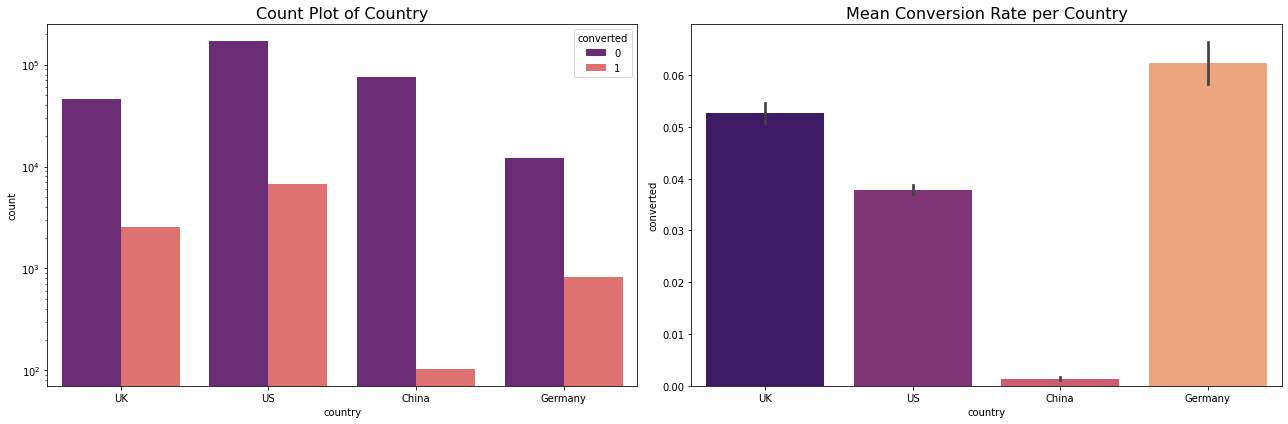

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data,palette = 'magma', ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, palette = 'magma', ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

**Results**
1. Conversion rate is very low at 3.2%
2. This is an imbalanced dataset. If we classify all the observations as 
   no-conversion we would still have 96% accuracy. Thus, we cannot use accuracy as an evaluation metric.
3. US has a lot of traffic but low conversion rate.
4. China has the least amount of conversion rate.
5. Germany has the least amount of traffic but a lot of them convert.

### Conversion By New User

In [16]:
cnt = data[['new_user','converted']].groupby('new_user').count().reset_index()
cnt

,new_user,converted
0,0,99454
1,1,216744


In [17]:


grouped_user = data[['new_user','converted']].groupby('new_user').mean().reset_index()
grouped_user

,new_user,converted
0,0,0.071983
1,1,0.014021


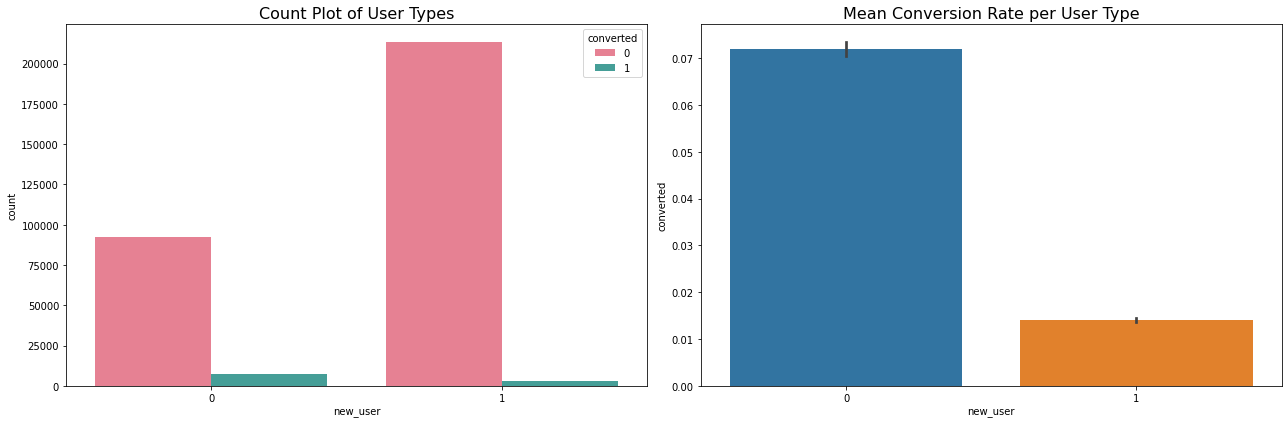

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted',palette = 'husl', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

### Results: 
1. A lot of new users land on the website but very few convert
2. A lot of the conversion is driven by old users.

### Conversion By Source

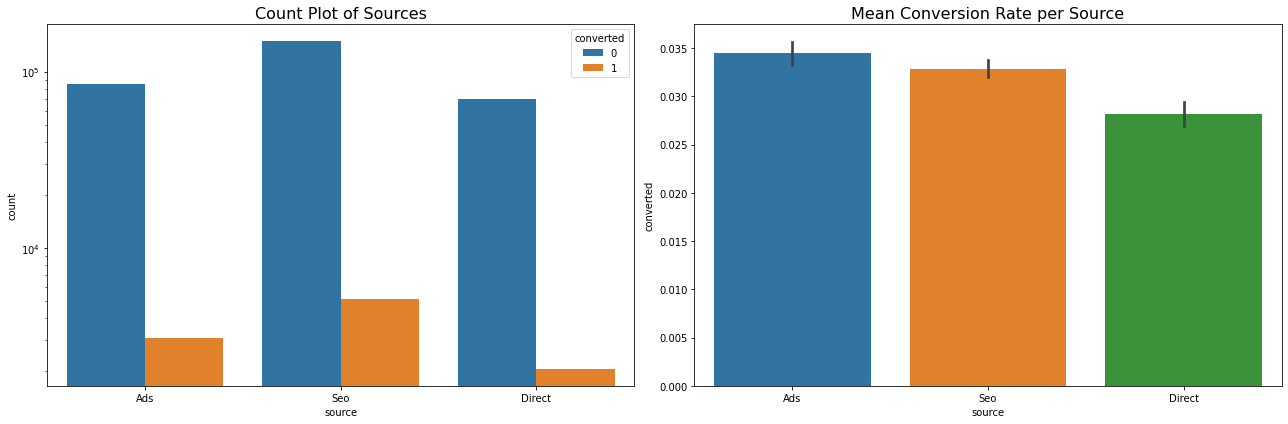

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

**Results**:
1. A lot of users come to the site via Search Engine and a lot of them convert too.
2. Users who come via ads have highest conversion rate
3. Few users use the direct channel and have the lowest conversion rate.

### Conversion By Age

In [22]:
grouped_age = data[['age', 'converted']].groupby('age').mean().reset_index()

Text(0.5, 1.0, 'Count Plot of Age')

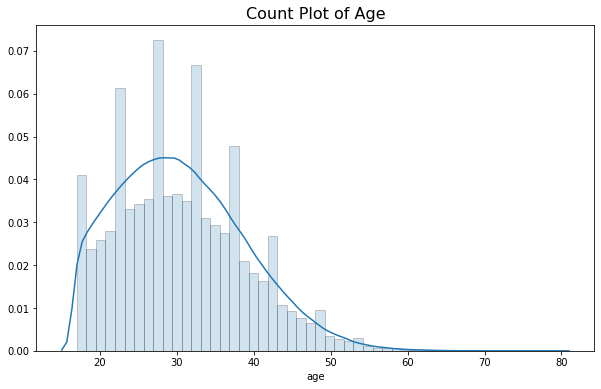

In [27]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(data['age'],hist_kws=hist_kws,ax = ax)
ax.set_title('Count Plot of Age',fontsize=16)

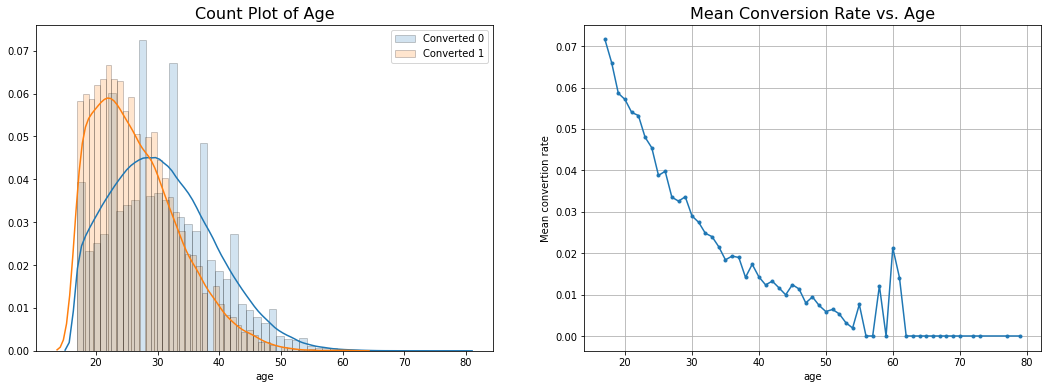

In [54]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age By Conversion', fontsize=16)
ax[0].legend()
ax[1].plot(grouped_age['age'], grouped_age['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

**Results**:
1. Most shoppers are between the age of 20-50 years.
2. A lot of the users who do convert are in the age group of 20-30 years.
3. People who don't convert are mostly above 30 years of age. 
4. Mean Conversion Rate declines as age increases.


### Conversion rate by Pages Visited

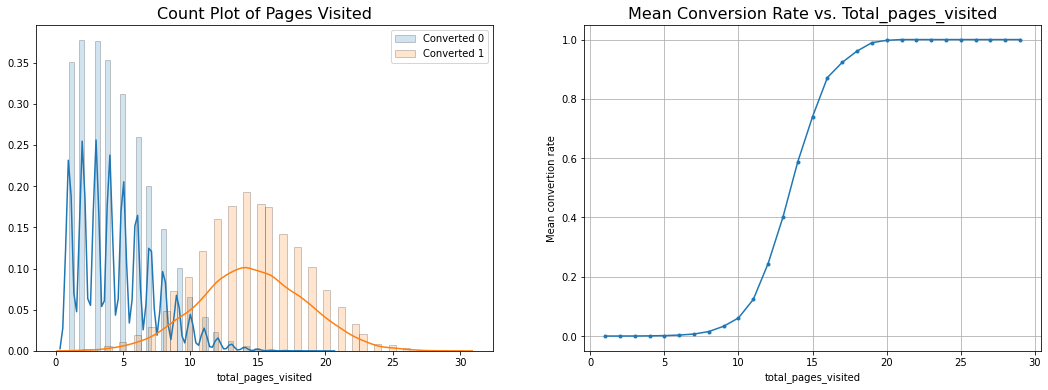

In [56]:
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Pages Visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

**Results**:
1. Users who do convert visit a lot more pages than users who don't convert
2. Conversion Rate increases by 60% if more than 15 pages have been visited.
3. A lot of the users who do convert visit anywhere from 10-20 pages.

## Bi-variate Analysis

Bivariate analysis is the simultaneous analysis of two variables (attributes). It explores the concept of relationship between two variables, whether there exists an association and the strength of this association, or whether there are differences between two variables and the significance of these differences. 

### Conversion rate by Age and Source

In [31]:
data_age_src = data[['source','age','converted']].groupby(['source','age','converted']).size().to_frame('size').reset_index()


The shaded box represents the values between 25-quartile and 75-quartile. The horizontal line in the shaded box shows the median. Two horizontal lines at the bottom and at the top represent the minimum, and the maximum value respectively. Using these plots we can compare values for different categories in a single graph. We can infer from the given graph that the age of the users who do convert is below 50 years for all the channels.

Text(0.5, 0.98, 'Box Plot of Source by Age')

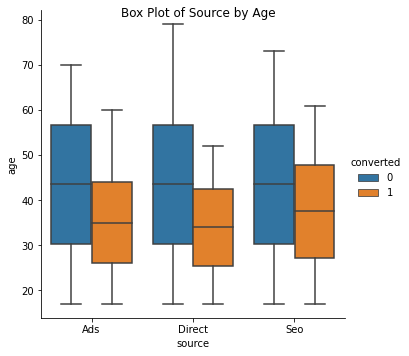

In [34]:
ax = sns.catplot(x="source", y="age", hue="converted", kind="box", data=data_age_src);
ax.fig.suptitle('Box Plot of Source by Age')

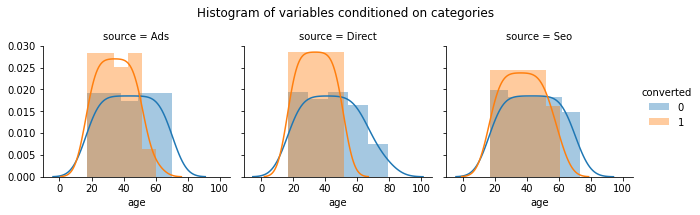

In [35]:
g = sns.FacetGrid(data=data_age_src, col='source',hue = 'converted')
g = g.map(sns.distplot,"age",hist = True,bins = 5,norm_hist = True)
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Histogram of variables conditioned on categories')
g.add_legend()
fig.set_size_inches(15, 15)
plt.show()

**Results**:
There is no difference in the age of the users who land on the webiste via different sources.
However, a lot of the young users come via the Direct and Ads source as opposed to SEO.

### Conversion By Country and Source

In [36]:
data_src_co = data[['country','source','converted']].groupby(['country','source','converted']).size().to_frame('size').reset_index()

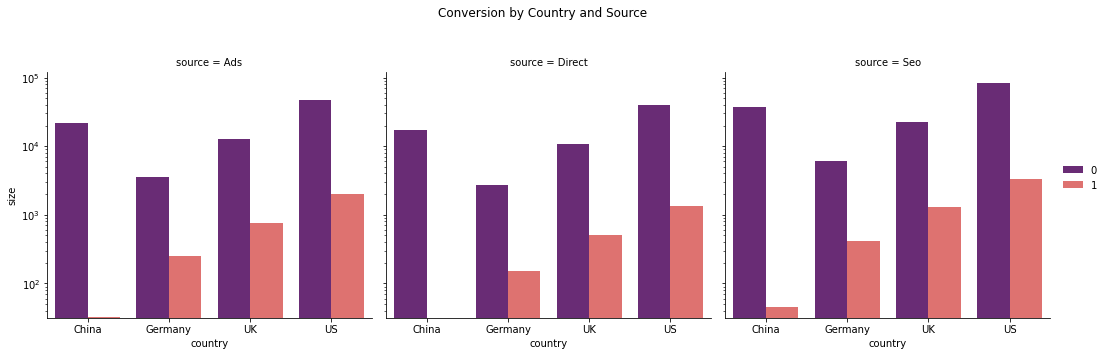

In [41]:
g = sns.FacetGrid(data=data_src_co, col='source',height = 5)
g = g.map(sns.barplot,"country","size","converted",palette="magma").set(yscale="log")
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Conversion by Country and Source')
g.add_legend()
fig.set_size_inches(10,10)
plt.show()

**Results**:

1. China has almost zero conversion via ads and Direct channels.
1. All the countries get most of their traffic from Seo, followed by Ads and lastly, Direct.

# Prediction

### Data Preparation

We can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a “dummy” variable for each possible category of each non-numeric feature.

***One Hot encoding for categorical data***

In [10]:
X_new = pd.get_dummies(data)

In [11]:
X_new = X_new.loc[:,X_new.columns!='converted']
X_new

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,1,0,0
316196,27,1,6,0,0,0,1,0,1,0
316197,25,0,4,1,0,0,0,1,0,0
316198,22,0,4,0,0,0,1,0,0,1


### Normalization of Numerical Features

Since, we are using regularization, we must scale the numerical inputs such as age and total_pages_visited.Normalization ensures that each feature is treated equally when applying supervised learners.

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num = ['age','total_pages_visited']
X = X_new.copy()
X[num] = scaler.fit_transform(X_new[num])
X_new.head(10)

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1
5,31,0,1,0,0,0,1,0,0,1
6,27,1,4,1,0,0,0,0,0,1
7,23,0,4,0,0,0,1,1,0,0
8,29,0,4,0,0,1,0,0,1,0
9,25,0,2,0,0,0,1,1,0,0


In [13]:
X.head(10)

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,0.129032,1,0.000000,0,0,1,0,1,0,0
1,0.096774,1,0.142857,0,0,0,1,0,0,1
2,0.177419,1,0.107143,0,0,0,1,0,0,1
3,0.354839,1,0.142857,1,0,0,0,0,0,1
4,0.209677,1,0.178571,0,0,0,1,0,0,1
5,0.225806,0,0.000000,0,0,0,1,0,0,1
6,0.161290,1,0.107143,1,0,0,0,0,0,1
7,0.096774,0,0.107143,0,0,0,1,1,0,0
8,0.193548,0,0.107143,0,0,1,0,0,1,0
9,0.129032,0,0.035714,0,0,0,1,1,0,0


In [14]:
y = data.converted

In [15]:
y.mean()

0.03225194340255157

### Data Split into Test and Train
Now that data preprocessing is complete,we will split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [16]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state = 42)

In [17]:
len(Xtrain),len(Xtest),len(ytrain),len(ytest),ytrain.mean(),ytest.mean()

(252958, 63240, 252958, 63240, 0.032270179239241296, 0.03217900063251107)

## Model Evaluation
Here, we will evaluate different classification algorithms and determine which is best at predicting the outcome that is conversion.

### Naive Prediction
Looking at the distribution of classes (those who converted vs those who don't), it’s clear most users don't convert. This can greatly affect accuracy, since we could simply say “this user does not convert” and be right 96% of the times! Making such a statement would be called naive, since we have not considered any information to substantiate the claim. In such a scenario, accuracy is not a good measure to evaluate a model's performance. We have to look at precision and recall which is the false positive and false negative rate respectively. 

## Supervised Learning Algorithms 

We will evaluate Logistic Regression, Decision Trees and Ensemble Models such as Random Forest and Gradient Boosted Decision Trees.

### Logistic Regression

In [18]:
clf = LogisticRegression()
clf.fit(Xtrain,ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred = clf.predict(Xtest)
print(classification_report(y_true = ytest, y_pred=y_pred))
accuracy = accuracy_score(ytest,y_pred)
print('Accuracy: ',accuracy)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.87      0.69      0.77      2035

    accuracy                           0.99     63240
   macro avg       0.93      0.84      0.88     63240
weighted avg       0.99      0.99      0.99     63240

Accuracy:  0.9865275142314991


We can see Precision is higher than recall which means False positives is lower than false negatives. The unoptimized accuracy is 98.6%. Let's tune the parameters and see if we can improve the results.

## Model Tuning
Using grid search (GridSearchCV) with different parameter/value combinations, we can tune our model for even better results.

In [20]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1]
param_grid = [{'penalty': ('l1', 'l2'),
             'C': param_range}]

In [21]:
gs = GridSearchCV(estimator=LogisticRegression(max_iter=100,solver = 'liblinear'),param_grid=param_grid, cv=3,
                  scoring='f1',
                  verbose =0)
gs = gs.fit(Xtrain, ytrain)
gs

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1],
                          'penalty': ('l1', 'l2')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [22]:
print("Model best score: %f" %gs.best_score_)
print("model best parameters: " + str(gs.best_params_))

Model best score: 0.760431
model best parameters: {'C': 1, 'penalty': 'l1'}


***Now we use the best parameters chosen by GridSearchCV to fit a model to our data***

In [23]:
clf_log = gs.best_estimator_
clf_log.fit(Xtrain, ytrain)
print('Test Accuracy: %.5f' %clf_log.score(Xtest, ytest))
print('Train Accuracy: %.5f' %clf_log.score(Xtrain,ytrain))

Test Accuracy: 0.98656
Train Accuracy: 0.98609


In [24]:
y_predict = clf_log.predict(Xtest)
print(classification_report(y_true = ytest, y_pred=y_predict))
accuracy = accuracy_score(ytest,y_predict)
print('Accuracy: ',accuracy)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.86      0.69      0.77      2035

    accuracy                           0.99     63240
   macro avg       0.93      0.84      0.88     63240
weighted avg       0.99      0.99      0.99     63240

Accuracy:  0.9865591397849462


It shows that for class converted, if we use the default cutoff 0.5, we can have a high precision (0.86), but a relative low recall 0.69, which means we classify 30% of converted user are classified as non-converted. In practice, we can choose a specific value for recall or precision by adjusting threshold according to our business goal. If False positives is expensive i.e if we say someone converted when they did not then precision should be improved. However, if false negatives are important then recall should be improved.

### Confusion Matrix
Visualize the confusion matrix for the results.

In [71]:
confmat = confusion_matrix(ytest, y_predict)



Text(0, 0.5, 'true value')

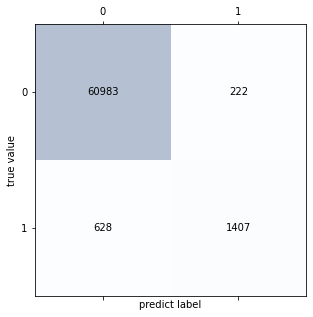

In [72]:
#Plot confusion matrix

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat,cmap = plt.cm.Blues,alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i,j],
               va = "center", ha = "center")

plt.xlabel('predict label')
plt.ylabel('true value')      

### Performance Metrics

### ROC-AUC Curve
An ROC curve plots the true positive rate on the y-axis versus the false positive rate on the x-axis. The true positive rate (TPR) is the recall and the false positive rate (FPR) is the probability of a false alarm. Both of these can be calculated from the confusion matrix:
Generally, as we decrease the threshold, we move to the right and upwards along the curve. With a threshold of 1.0, we would be in the lower left of the graph because we identify no data points as positives leading to no true positives and no false positives (TPR = FPR = 0). As we decrease the threshold, we identify more data points as positive, leading to more true positives, but also more false positives (the TPR and FPR increase). Eventually, at a threshold of 0.0 we identify all data points as positive and find ourselves in the upper right corner of the ROC curve (TPR = FPR = 1.0)

In [25]:
#accuracy = accuracy_score(ytest,y_predict)
y_pred_new_threshold = (clf_log.predict_proba(Xtest)[:,1]>=0.4).astype(int)

In [27]:
accuracy_score(ytest,y_pred_new_threshold)


0.986100569259962

In [ ]:
precisions_test, , t = precision_recall_curve(ytest, y_pred_prob[:,1])
PR_train = auc(recalls,precisions)
PR_test = auc(recalls_test,precisions_test)

Area under the Receiver Operating Characteristic Curves (ROC AUC) is 0.986288 


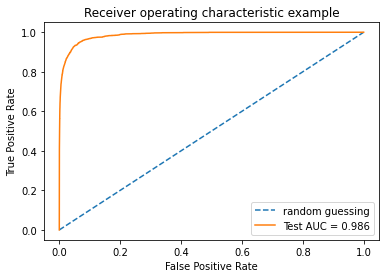

In [32]:
#Roc curve
y_pred_prob = clf_log.predict_proba(Xtest)
y_train_prob = clf_log.predict_proba(Xtrain)

fpr,tpr,threshold = roc_curve(ytest, y_pred_prob[:, 1])
roc_auc_test = auc(fpr, tpr)

print("Area under the Receiver Operating Characteristic Curves (ROC AUC) is %f " 
      %(roc_auc_score(ytest, y_pred_prob[:,1])))



# Plot ROC curve and compare them


plt.figure()
plt.plot([0,1],[0,1], linestyle = '--', label = 'random guessing')
plt.plot(fpr, tpr, label='Test AUC = %0.3f'% roc_auc_score(ytest, y_pred_prob[:,1]) )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')



Here looking at the ROC curve (and the ROC AUC score),we can say classifier performs well. The TPR here is the ratio of (postive)converted users that are correctly classified as converted group, which is large in this case. The FPR is the ratio of (negative) nonconverted users that are incorrectly classfied as (positive)converted. However, due to the imbalance in the data set, i.e. there are few converted users(positive) compared to the nonconverted ones(negative). Consequently, it makes sense that TPR will be large and we will have low False positive rate. This is not a good estimate since our dataset is imbalanced. Hence, we will use Precision-Recall Curve. 

### Precision-Recall Curve
Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1.

A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve.

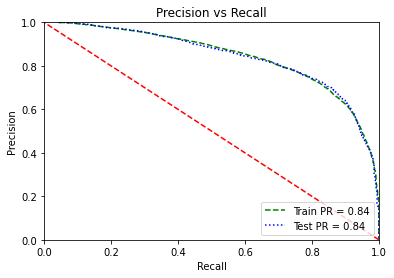

In [114]:
#Precision Recall Plot
precisions, recalls, thresholds = precision_recall_curve(ytrain, y_train_prob[:,1] )
precisions_test, recalls_test, thresholds = precision_recall_curve(ytest, y_pred_prob[:,1])
PR_train = auc(recalls,precisions)
PR_test = auc(recalls_test,precisions_test)
plt.plot(precisions,recalls,'g--',label='Train PR = %0.2f'% PR_train)
plt.plot(precisions_test,recalls_test,'b:',label='Test PR = %0.2f'% PR_test)
plt.legend(loc="lower right")
plt.plot([1, 0], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.title('Precision vs Recall')
plt.ylabel('Precision')
plt.xlabel('Recall');

In [95]:
fscore = (2 * precisions_test * recalls_test) / (precisions_test + recalls_test)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.434684, F-Score=0.774


The optimal threshold with best F1-score is 0.4. Thus, if we predict every user with a probability greater than or equal to 0.4 as "converted" then we get a balanced precision and recall.

## Feature Importance
An important task when performing supervised learning on a dataset is to study which features provide the most predictive power. 

In [97]:
feature_imp = pd.DataFrame({'name':X_new.columns,'coefcients':clf_log.coef_[0]})
feature_imp['importance'] = np.abs(feature_imp['coefcients'])
feature_imp.sort_values(by = 'importance',inplace = True,ascending = False)
feature_imp

,name,coefcients,importance
2,total_pages_visited,21.187045,21.187045
0,age,-4.588671,4.588671
3,country_China,-3.747588,3.747588
1,new_user,-1.739224,1.739224
6,country_US,-0.566222,0.566222
5,country_UK,-0.184944,0.184944
8,source_Direct,-0.157429,0.157429
4,country_Germany,0.001996,0.001996
7,source_Ads,0.000000,0.000000
9,source_Seo,0.000000,0.000000


Total Pages visited is the most important feature. If total pages visited increases then the likelihood of conversion would be 21X times higher.

## Decision Tree

Strengths:
1. Able to handle categorical and numerical data.
2. Doesn’t require much data pre-processing, and can handle data which hasn’t been normalized, or encoded for Machine Learning Suitability.
3. Simple to understand and interpret.

In [99]:
param_range = [2, 3, 4, 5, 6]
param_grid = [{'criterion': ('gini', 'entropy'),
             'max_depth': param_range}]


***We will use GridCV to help us choose the best parameters for a Decision Tree***

In [100]:
gs2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),param_grid=param_grid, cv=3, scoring='f1')
gs2 = gs2.fit(Xtrain, ytrain)
gs2

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ('gini', 'entropy'),
                          'max_depth': [2, 3, 4, 5, 6]}],
         

In [101]:
print("Model best score: %f" %gs2.best_score_)
print("model best parameters: " + str(gs2.best_params_))

Model best score: 0.757430
model best parameters: {'criterion': 'gini', 'max_depth': 6}


We will fit decision tree model as per the best parameters chosen

In [102]:
clf2 = gs2.best_estimator_
clf2.fit(Xtrain, ytrain)
print('Test Accuracy: %.5f' %clf2.score(Xtest, ytest))

Test Accuracy: 0.98627


In [103]:
y_predict2 = clf2.predict(Xtest)
print(classification_report(y_true = ytest, y_pred=y_predict2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.85      0.69      0.76      2035

    accuracy                           0.99     63240
   macro avg       0.92      0.84      0.88     63240
weighted avg       0.99      0.99      0.99     63240



Test accuracy is 98.64% but since our dataset is imbalanced we will look at precision and recall. Precision is 85% but Recall is 69% so 30% of the times, our model predicts an unconverted user as converted.

Text(0, 0.5, 'true value')

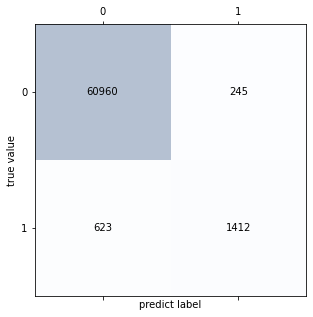

In [104]:
confmat2 = confusion_matrix(ytest, y_predict2)
confmat2
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat2,cmap = plt.cm.Blues,alpha = 0.3)
for i in range(confmat2.shape[0]):
    for j in range(confmat2.shape[1]):
        ax.text(x = j, y = i, s = confmat2[i,j],
               va = "center", ha = "center")

plt.xlabel('predict label')
plt.ylabel('true value') 

In [105]:
feature_imp2 = pd.DataFrame({'name':Xtrain.columns,'feature_imp':clf2.feature_importances_})
feature_imp2.sort_values(by = 'feature_imp',inplace = True,ascending = False)
feature_imp2

,name,feature_imp
2,total_pages_visited,0.880827
1,new_user,0.056873
3,country_China,0.042486
0,age,0.019624
8,source_Direct,0.000185
9,source_Seo,0.000003
7,source_Ads,0.000002
4,country_Germany,0.000000
5,country_UK,0.000000
6,country_US,0.000000


Decision Tree performs as well as Logistic Regression.

# Random Forest

In [107]:
param_range = [2, 3, 4, 5, 6, 9, 12]
param_grid = [{'criterion': ('gini', 'entropy'),'max_depth':param_range}]

We will use GridSearch to select max_depth and evaluation criterion

In [116]:
gs3 = GridSearchCV(estimator=RandomForestClassifier(random_state=1,max_features="sqrt"),param_grid=param_grid, cv=3,
                   scoring='f1')
gs3 = gs3.fit(Xtrain, ytrain)
gs3

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

In [117]:
print("Model best score: %f" %gs3.best_score_)
print("model best parameters: " + str(gs3.best_params_))

Model best score: 0.756708
model best parameters: {'criterion': 'entropy', 'max_depth': 9}


In [118]:
clf3 = gs3.best_estimator_
clf3.fit(Xtrain, ytrain)
print('Test Accuracy: %.5f' %clf3.score(Xtest, ytest))

Test Accuracy: 0.98642


In [119]:
y_predict3 = clf3.predict(Xtest)
print(classification_report(y_true = ytest, y_pred=y_predict3))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.86      0.69      0.77      2035

    accuracy                           0.99     63240
   macro avg       0.92      0.84      0.88     63240
weighted avg       0.99      0.99      0.99     63240



Text(0, 0.5, 'true value')

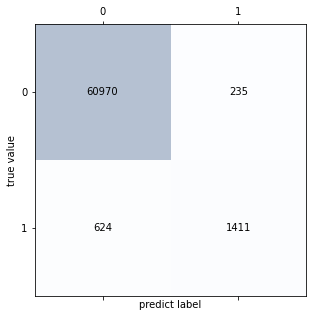

In [130]:
confmat3 = confusion_matrix(ytest, y_predict3)
confmat3
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat3,cmap = plt.cm.Blues,alpha = 0.3)
for i in range(confmat3.shape[0]):
    for j in range(confmat3.shape[1]):
        ax.text(x = j, y = i, s = confmat3[i,j],
               va = "center", ha = "center")

plt.xlabel('predict label')
plt.ylabel('true value') 

Random Forest performs as well as Logistic Regression when it comes to reducing misclassifications.

In [115]:
feature_imp3 = pd.DataFrame({'name':Xtrain.columns,'feature_imp':clf3.feature_importances_})
feature_imp3.sort_values(by = 'feature_imp',inplace = True,ascending = False)
feature_imp3

,name,feature_imp
2,total_pages_visited,0.823450
1,new_user,0.075413
3,country_China,0.044855
0,age,0.038065
6,country_US,0.006262
5,country_UK,0.005182
4,country_Germany,0.003596
8,source_Direct,0.001093
9,source_Seo,0.001052
7,source_Ads,0.001032


# Gradient Boosted Trees

In [121]:
param_range = [0.1]
depth_range = [12,15]
param_grid = [{'max_depth': depth_range,'learning_rate':param_range}]

In [123]:
gs4 = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1,max_features="sqrt"), param_grid=param_grid, cv=3, scoring='roc_auc')
gs4 = gs4.fit(Xtrain, ytrain)
gs4


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
       

In [124]:
print("Model best score: %f" %gs4.best_score_)
print("model best parameters: " + str(gs4.best_params_))

Model best score: 0.970084
model best parameters: {'learning_rate': 0.1, 'max_depth': 12}


In [125]:
clf4 = gs4.best_estimator_
clf4.fit(Xtrain, ytrain)
print('Test Accuracy: %.5f' %clf4.score(Xtest, ytest))

Test Accuracy: 0.98518


In [126]:
y_predict4 = clf4.predict(Xtest)
print(classification_report(y_true = ytest, y_pred=y_predict4))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.83      0.68      0.75      2035

    accuracy                           0.99     63240
   macro avg       0.91      0.84      0.87     63240
weighted avg       0.98      0.99      0.98     63240



Text(0, 0.5, 'true value')

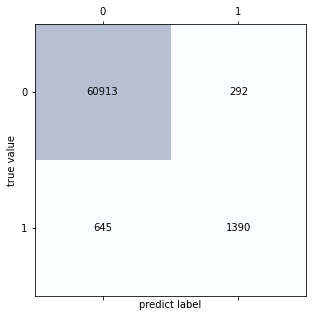

In [129]:
confmat4 = confusion_matrix(ytest, y_predict4)
confmat4
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat4,cmap = plt.cm.Blues,alpha = 0.3)
for i in range(confmat4.shape[0]):
    for j in range(confmat4.shape[1]):
        ax.text(x = j, y = i, s = confmat4[i,j],
               va = "center", ha = "center")

plt.xlabel('predict label')
plt.ylabel('true value') 

Gradient Boosted Trees have not performed as well as Random Forest. Accuracy is almost the same but Precision and Recall is low.

### Model Comparison

***We will compare all the tuned models to choose a final model based on F1 score***

In [128]:
#Summary
clf_labels = ['Logistic regression', 'Decision tree Classifier', 'Random Forest Classifier','Gradient Boosted Trees']
print('5-fold cross validation Summary:\n')

for clf,label in zip([clf_log,clf2,clf3,clf4],clf_labels):
    scores = cross_val_score(estimator=clf, X=Xtrain, y=ytrain, cv=5, scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f) [%s] " % (scores.mean(), scores.std(),label))
    

5-fold cross validation Summary:

F1 Score: 0.76 (+/- 0.01) [Logistic regression] 
F1 Score: 0.76 (+/- 0.01) [Decision tree Classifier] 
F1 Score: 0.76 (+/- 0.01) [Random Forest Classifier] 
F1 Score: 0.74 (+/- 0.01) [Gradient Boosted Trees] 


All the models perform fairly well and provide same results. Given our dataset, precision and recall cannot be improved further. 

## Recommendations

Based on above model and data visualization, here are some suggestions :

1. Total pages visited is the most important one for conversion rate. This is reasonable and intuitive because users browsing many pages tend to buy something. They might have a goal so they need to visit mutiple pages and complete payment. What we should do first is to stimulate users without clear shopping goal to click, which means except for what they search, our website should provide recommendations that would result in more clicks, then they might want to buy, probably take action and finally be converted.

2. We see a large number of users  are first time buyers and the rest are repeat users, and probability of conversion of old users is nearly five times than that of new users. Thus, it is very important to retain old customers in order to fortify our business. Consequently, we should further focus on customer retention rate and make a trade-off between targeting old customers and find new users for marketing and sale teams. Also, we can get some actionable insight from this dataset, for example, target new users with total pages visited over 15, analyze the reason why they don't buy what they visited, maybe they were comparing the price with other website or they might care for comments. If they are sensitive to promotions or coupons, then we can send them relative news and coupons.

3. We see a lot of the users that convert are younger than 55 years. Thus, for marketing teams, we should make this age group our target audience. Meanwhile, older people might be unwilling to shop online. I think we can collect more data to try and identify the reason why they don't like to use our website. If it is actionable, we can update and correct it to convert more older users.

4. As for the conversion rate by country, we can see that China has the most impact among all four countries, which is comprehensible. We have analyzed before that there are many users in China, but mean conversion rate is extremely low. Most of the users that do convert use SEO channel. I think we should fully dig into user's shopping experience, because they are visiting our website and the number of users are huge, which means they are interested in what we sell and offer, but they don't take action. It shows that there maybe something wrong with our website in China, for example, delivery, return, exchange, translation and payment way, etc. This can not be solved by a simple A/B testing setup, we might try to analyze the user activity logs, conduct retrospective analysis or conduct user experience research. If we could figure out concrete reason, then conversion rate definitely might have a big improvement.

5. Users mainly originate from United States but their conversion rate is not number one. It is highly likely that our website is from US and people here may have a lot of other options.We should do a competitive analysis to remain competitive on the market. Website in Germany has the fewest users but the highest conversion rate. It is a big opportunity for our website in Germany if we can expand our business due to high conversion rate.

6. Although how people come to our website is not that important compared to other variables, we can see that users who are attracted by advertisement(Ads) have the highest mean conversion rate, which indicates if our advertisement system can target the potential customers precisely, then conversion performance will improve a lot.